<a href="https://colab.research.google.com/github/RaulAtLehigh/CSE337_P1/blob/main/lab10_half_cheetah_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll

1. Collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`
2. Train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and
3. **Validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [6]:
import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

#create tensor from array (or other data)
def to_t(x):
    return th.as_tensor(x, dtype=th.float32)

# iniitializing the neural network w/ weights
def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        # Initialize the RunningNormalizer with the dimension of the data
        self.dim = dim
        # Count of data points seen so far
        self.count = 0
        # Running mean, initialized to zeros
        self.mean = np.zeros(dim, dtype=np.float64)
        # Sum of squared differences from the mean (for calculating variance)
        self.M2   = np.zeros(dim, dtype=np.float64)
        # Small value added to variance to prevent division by zero
        self.eps  = eps

    # update the normalize values
    def update(self, x: np.ndarray):
        # Update the running mean and M2 with a new data point or batch
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :] # Handle single data points
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        # Calculate the running variance
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self):
        # Calculate the running standard deviation
        return np.sqrt(self.var + self.eps)

    def normalize(self, x):
        # Normalize the input data using the current mean and std
        return (x - self.mean) / self.std
    def denormalize(self, x):
        # Denormalize the data
        return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)


## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [7]:

set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1) #q_vel has 9 elements
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)


obs_dim: 17 act_dim: 6 qvel_start: 8


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [8]:
# Create the class and create a class object
class Replay:
    def __init__(self, obs_dim, act_dim, capacity=300000):
        self.obs = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.act = np.zeros((capacity, act_dim), dtype=np.float32)
        self.nxt = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.rew = np.zeros((capacity, 1), dtype=np.float32)
        self.term = np.zeros((capacity, 1), dtype=np.float32)
        self.ptr = 0; self.size = 0; self.cap = capacity

    def add(self, s, a, r, sp, term):
        if (self.cap - self.size) % self.cap == 0:
          self.ptr = 0

        self.obs[self.ptr] = s
        self.rew[self.ptr] = r
        self.nxt[self.ptr] =  sp
        self.act[self.ptr] =  a
        self.term[self.ptr] = term
        self.size += 1
        self.ptr += 1

    def sample(self, batch):
      maxind = self.size if self.size < self.cap else self.cap - 1
      indices = np.random.randint(0, maxind, size=batch)
      return (
          self.obs[indices],
          self.act[indices],
          self.nxt[indices],
          self.rew[indices],
          self.term[indices],
      )


replay = Replay(obs_dim, act_dim)


## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps.
- Call the function and fill the replay buffer


In [9]:

def collect_random(env, replay, steps=10000, seed=42):
    state = env.reset()[0]
    for i in range(steps):
      random_actions = np.random.default_rng().uniform(low=-1, high=1, size=act_dim) # random action
      next_state, reward, term, trunc, done = env.step(random_actions)
      replay.add(state, random_actions, reward, next_state, term)
      if term:
        state = env.reset()[0]

collect_random(env, replay, 300000,)






## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [10]:
obs_norm = RunningNormalizer(obs_dim)
# for the input that goes into our MLP
inp_norm = RunningNormalizer(obs_dim + act_dim) #[s, a]
# normalizing target output (state delta - s(t+1) - s(t))
targ_norm = RunningNormalizer(obs_dim)

# write the function to update the normalizers from the data collected in the buffer
def update_normalizers_from_buffer(replay):
    for i in range(replay.size):
        obs = replay.obs[i]
        act = replay.act[i]
        nxt = replay.nxt[i]

        obs_norm.update(obs)
        inp_norm.update(np.concatenate([obs, act]))
        targ_norm.update(nxt - obs)


update_normalizers_from_buffer(replay)
print("Normalizers ready.")

Normalizers ready.



## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters:

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters.


In [13]:
class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=512, depth=3): # Increased width to 1024
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

in_dim = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=1024, depth=3)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)


## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch.
- Train for 30 epochs and plot the training curve. Loss vs epoch.
- Find the best parameters(defined in the previous block)



Epoch 1/30, Loss: 0.639271, LR: 0.000800
Epoch 2/30, Loss: 0.629662, LR: 0.000640
Epoch 3/30, Loss: 0.629747, LR: 0.000512
Epoch 4/30, Loss: 0.634328, LR: 0.000410
Epoch 5/30, Loss: 0.634868, LR: 0.000328
Epoch 6/30, Loss: 0.630540, LR: 0.000262
Epoch 7/30, Loss: 0.632990, LR: 0.000210
Epoch 8/30, Loss: 0.629873, LR: 0.000168
Epoch 9/30, Loss: 0.627567, LR: 0.000134
Epoch 10/30, Loss: 0.633327, LR: 0.000107
Epoch 11/30, Loss: 0.628054, LR: 0.000086
Epoch 12/30, Loss: 0.629602, LR: 0.000069
Epoch 13/30, Loss: 0.626240, LR: 0.000055
Epoch 14/30, Loss: 0.631080, LR: 0.000044
Epoch 15/30, Loss: 0.628397, LR: 0.000035
Epoch 16/30, Loss: 0.629143, LR: 0.000028
Epoch 17/30, Loss: 0.628584, LR: 0.000023
Epoch 18/30, Loss: 0.633603, LR: 0.000018
Epoch 19/30, Loss: 0.627506, LR: 0.000014
Epoch 20/30, Loss: 0.628650, LR: 0.000012
Epoch 21/30, Loss: 0.635240, LR: 0.000009
Epoch 22/30, Loss: 0.630788, LR: 0.000007
Epoch 23/30, Loss: 0.634897, LR: 0.000006
Epoch 24/30, Loss: 0.632013, LR: 0.000005
E

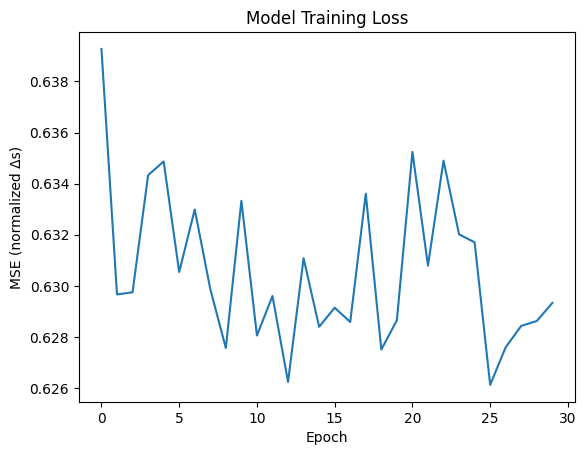

In [14]:
def train_model(model, replay, epochs=30, batch_size=256):
    losses = []
    MSE = nn.MSELoss() # Mean Squared Error Loss
    for e in range(epochs):
        epoch_loss = 0
        num_batches = replay.size // batch_size # Integer division to get number of full batches
        if replay.size % batch_size != 0:
            num_batches += 1 # Add one for the last partial batch

        for _ in range(num_batches):
            obs, act, nxt, rew, term = replay.sample(batch_size)

            # Convert to tensors
            obs = to_t(obs.astype(np.float32))
            act = to_t(act.astype(np.float32))
            nxt = to_t(nxt.astype(np.float32))

            # Calculate state delta and normalize
            delta_s = nxt - obs
            normalized_delta_s = to_t(targ_norm.normalize(delta_s.detach().numpy().astype(np.float32)))

            # Prepare and normalize input for the model
            model_input = th.cat([obs, act], dim=-1)
            normalized_model_input = to_t(inp_norm.normalize(model_input.detach().numpy().astype(np.float32))) # Normalize

            # Zero the gradients
            opt.zero_grad()

            # Forward pass
            predicted_normalized_delta_s = model(normalized_model_input)

            # Calculate loss
            loss = MSE(predicted_normalized_delta_s, normalized_delta_s)

            # Backward pass and optimize
            loss.backward()
            opt.step()

            epoch_loss += loss.item()

        # Decay learning rate
        scheduler.step()
        losses.append(epoch_loss / num_batches)
        # Average loss per epoch
        print(f"Epoch {e+1}/{epochs}, Loss: {losses[-1]:.6f}, LR: {scheduler.get_last_lr()[0]:.6f}")


    return losses

# train_model(model, replay, epochs=1, batch_size=1)
losses = train_model(model, replay, epochs=30, batch_size=256)
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δs)")
plt.title("Model Training Loss")
plt.show()

## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

One-step prediction MSE: 8.304111


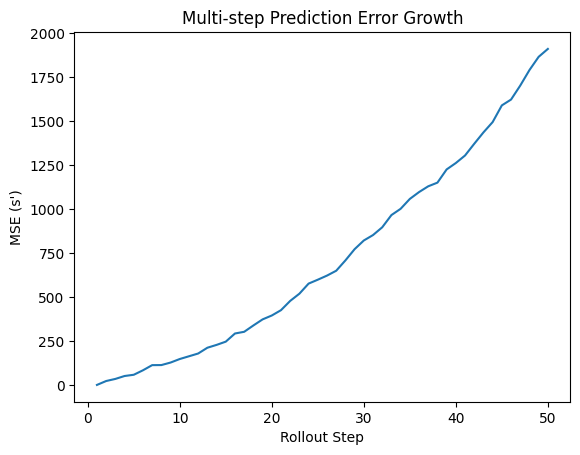

Multi-step prediction MSE growth:
[1.12350141e+00 2.32981294e+01 3.51988979e+01 5.17759748e+01
 5.88289114e+01 8.42393591e+01 1.13512482e+02 1.13882719e+02
 1.28230798e+02 1.48313494e+02 1.63896321e+02 1.79580394e+02
 2.12417262e+02 2.28519217e+02 2.46971621e+02 2.93280720e+02
 3.02936302e+02 3.38931402e+02 3.73434782e+02 3.95507264e+02
 4.25790390e+02 4.78431412e+02 5.19386626e+02 5.76721536e+02
 5.98891526e+02 6.22230161e+02 6.49774949e+02 7.08485025e+02
 7.72345791e+02 8.21616778e+02 8.52485588e+02 8.96563384e+02
 9.66034818e+02 1.00159684e+03 1.05776697e+03 1.09658810e+03
 1.12950986e+03 1.15026601e+03 1.22531183e+03 1.26172763e+03
 1.30446837e+03 1.37105754e+03 1.43568785e+03 1.49432007e+03
 1.58916961e+03 1.62230145e+03 1.70176265e+03 1.78982856e+03
 1.86506567e+03 1.90992176e+03]


array([1.12350141e+00, 2.32981294e+01, 3.51988979e+01, 5.17759748e+01,
       5.88289114e+01, 8.42393591e+01, 1.13512482e+02, 1.13882719e+02,
       1.28230798e+02, 1.48313494e+02, 1.63896321e+02, 1.79580394e+02,
       2.12417262e+02, 2.28519217e+02, 2.46971621e+02, 2.93280720e+02,
       3.02936302e+02, 3.38931402e+02, 3.73434782e+02, 3.95507264e+02,
       4.25790390e+02, 4.78431412e+02, 5.19386626e+02, 5.76721536e+02,
       5.98891526e+02, 6.22230161e+02, 6.49774949e+02, 7.08485025e+02,
       7.72345791e+02, 8.21616778e+02, 8.52485588e+02, 8.96563384e+02,
       9.66034818e+02, 1.00159684e+03, 1.05776697e+03, 1.09658810e+03,
       1.12950986e+03, 1.15026601e+03, 1.22531183e+03, 1.26172763e+03,
       1.30446837e+03, 1.37105754e+03, 1.43568785e+03, 1.49432007e+03,
       1.58916961e+03, 1.62230145e+03, 1.70176265e+03, 1.78982856e+03,
       1.86506567e+03, 1.90992176e+03])

In [15]:
# One-step prediction error
def evaluate_one_step(model, env, replay, batch_size=1000):
    # Generate a batch
    obs, act, nxt, rew, term = replay.sample(batch_size)

    # Convert to tensors
    obs_t = to_t(obs.astype(np.float32))
    act_t = to_t(act.astype(np.float32))
    nxt_t = to_t(nxt.astype(np.float32))

    true_delta_s = nxt_t - obs_t
    model_input = th.cat([obs_t, act_t], dim=-1)
    normalized_model_input = to_t(inp_norm.normalize(model_input.detach().numpy().astype(np.float32)))
    predicted_normalized_delta_s = model(normalized_model_input)

    predicted_delta_s = to_t(targ_norm.denormalize(predicted_normalized_delta_s.detach().numpy().astype(np.float32)))

    mse = nn.functional.mse_loss(predicted_delta_s, true_delta_s)

    print(f"One-step prediction MSE: {mse.item():.6f}")
    return mse.item()

# Multi-step open-loop rollout error
def evaluate_multi_step(model, env, replay, rollout_length=50, num_rollouts=10):
    mse_per_step = np.zeros(rollout_length)

    for _ in range(num_rollouts):
        # differentiating between state and model
        real_state = env.reset()[0]
        model_state = real_state.copy()

        # action roll out
        actions = [env.action_space.sample() for _ in range(rollout_length)]

        for k in range(rollout_length):
            # Step the real environment
            next_real_state, reward, term, trunc, info = env.step(actions[k])

            model_input = np.concatenate([model_state, actions[k]])
            normalized_model_input = to_t(inp_norm.normalize(model_input.astype(np.float32)))

            predicted_normalized_delta_s = model(normalized_model_input)
            predicted_delta_s = to_t(targ_norm.denormalize(predicted_normalized_delta_s.detach().numpy().astype(np.float32)))

            # Predict the next state using the model
            predicted_next_state = model_state + predicted_delta_s.detach().numpy()

            # Calculate MSE for this step and add to the running sum
            mse_per_step[k] += np.mean((predicted_next_state - next_real_state)**2)

            model_state = predicted_next_state.copy()
            real_state = next_real_state.copy()

            # If the real environment terminated or truncated, stop this rollout
            if term or trunc:
                break


    # Average the MSE over all rollouts
    mse_per_step /= num_rollouts

    plt.figure()
    plt.plot(range(1, rollout_length + 1), mse_per_step)
    plt.xlabel("Rollout Step")
    plt.ylabel("MSE (s')")
    plt.title("Multi-step Prediction Error Growth")
    plt.show()

    print("Multi-step prediction MSE growth:")
    print(mse_per_step)
    return mse_per_step

# Assuming the model is already trained and normalizers are updated
evaluate_one_step(model, env, replay, batch_size=1000)
evaluate_multi_step(model, env, replay, rollout_length=50, num_rollouts=10)


## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



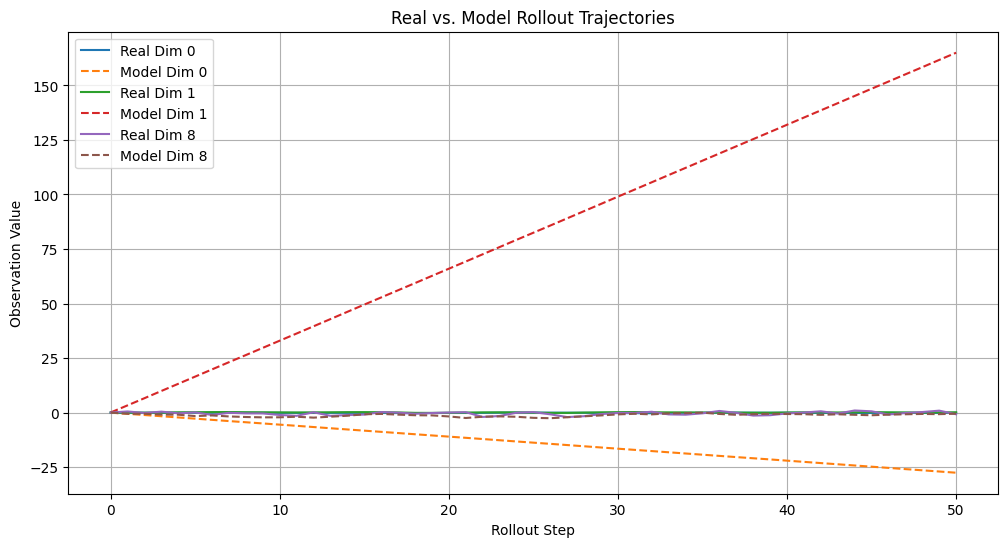

In [16]:
def visualize_rollout(env, model, k=50, dims=None, seed=2025):
    """
    Visualizes rollout trajectories of the real environment and the model.

    Args:
        env: The Gymnasium environment.
        model: The trained dynamics model.
        k: The number of steps to rollout.
        dims: A list or tuple of observation dimensions to plot. If None, plots all dimensions.
        seed: The seed for resetting the environment and sampling actions.
    """
    # Set model to evaluation mode
    model.eval()

    # Reset the environment with the provided seed and keep the initial observation
    real_state, _ = env.reset(seed=seed)
    model_state = real_state.copy()

    # Store trajectories
    real_trajectory = [real_state]
    model_trajectory = [model_state]

    # Choose actions: pre-sample k actions
    rng = np.random.default_rng(seed) # Use a separate RNG for actions for reproducibility
    actions = [env.action_space.sample() for _ in range(k)]

    # Roll forward
    for i in range(k):
        action = actions[i]

        # Step the real environment
        next_real_state, reward, term, trunc, info = env.step(action)
        real_trajectory.append(next_real_state)

        # Model path
        with th.no_grad(): # Ensure no gradients are computed
            # Build model input [s_model, a]
            model_input = np.concatenate([model_state, action])

            # Normalize model input
            normalized_model_input = to_t(inp_norm.normalize(model_input.astype(np.float32)))

            # Run the network to predict normalized state delta
            predicted_normalized_delta_s = model(normalized_model_input)

            # Denormalize the predicted state delta
            predicted_delta_s = targ_norm.denormalize(predicted_normalized_delta_s.detach().numpy().astype(np.float32))

            # Add delta to the last model state to get predicted next state
            predicted_next_state = model_state + predicted_delta_s

            # Append predicted next state to model trajectory
            model_trajectory.append(predicted_next_state)

            # Update model state for the next step
            model_state = predicted_next_state.copy()


        # Stop early if the real environment terminates or truncates
        if term or trunc:
            print(f"Rollout stopped early at step {i+1} due to environment termination or truncation.")
            break

    # Convert trajectories to numpy arrays for easier plotting
    real_trajectory = np.array(real_trajectory)
    model_trajectory = np.array(model_trajectory)

    # Plot
    if dims is None:
        dims = range(real_state.shape[0]) # Plot all dimensions if none specified

    plt.figure(figsize=(12, 6))
    for d in dims:
        plt.plot(real_trajectory[:, d], label=f'Real Dim {d}')
        plt.plot(model_trajectory[:, d], label=f'Model Dim {d}', linestyle='--')

    plt.xlabel("Rollout Step")
    plt.ylabel("Observation Value")
    plt.title("Real vs. Model Rollout Trajectories")
    plt.legend()
    plt.grid(True)
    plt.show()

# Uncomment to visualize
dims = [0, 1, qvel_start] # Visualize dimensions 0, 1, and qvel_start (forward velocity)
visualize_rollout(env, model, k=50, dims=dims)


## 9. Answer the questions :

1. How good is your model?
2. Is this training enough for planning, or do we need continual training?
3. How is this system different from the mountain car problem? Why can't we learn this in one episode?
4. Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class.

With the original hyper parameters, my model was not very good. It had a high rate of loss however when I was able to better find the parameters (my model's width in particular) my model's loss decreased dramatically.

I don't think this is enough training and I believe we need to implement another on-policy model as we run more episodes on the model rather than just trying to loop through randomized batches to learn the dynamics.

The system is way different from the mountain car problems since it's so much more challenging for the model to learn. I think the main difference has to do with the dimensionality of the half cheetah in this case had 17 observations for us to make and a six dimensional action space whereas mountain car was dramatically lower. In order to learn in the high dimensional environment like this one we need way more training and data than we did with something like mountain car.

I think the reason we use running normalizer here is so that our model can learn on the fly rather than having to wait at the end of an epoch. Allowing this gave us more up-to-date information that allowed model to learn.

